In [1]:
import pandas as pd
import numpy as np
import os
import sys
import traceback

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import pickle
from tqdm import tqdm
import pydicom
import cv2
import glob, pylab

import PIL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,GlobalAveragePooling2D, ZeroPadding2D, Convolution2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten, Activation 
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

from tensorflow.keras.applications.imagenet_utils import decode_predictions 
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import MobileNet, VGG16, ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications.mobilenet import preprocess_input

In [64]:
prefix = './container'

IMG_ACTUAL_SIZE = 1024
input_path = os.path.join(prefix, 'input/data/')
output_path = os.path.join(prefix, 'output/')
model_path = os.path.join(prefix, 'model/')

training_path = os.path.join(input_path, 'stage_2_train_images/')
training_labels_path = input_path + 'stage_2_train_labels.csv'

print(training_path)
print(training_labels_path)

./container\input/data/stage_2_train_images/
./container\input/data/stage_2_train_labels.csv


In [80]:
def create_model(X_train, y_train):
    print('inside create_model')
    classifier = load_model(os.path.join(model_path,'mobilenet_model.h5'))

    # Compiling the MobileNet
    classifier.compile(
        optimizer='Adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # declare the callbacks
    callbacks = [
        EarlyStopping(patience=10, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
#         ModelCheckpoint(os.path.join(model_path,'model-classification.h5'), verbose=1, save_best_only=True, save_weights_only=True)
    ]
    # Fit gridsearch to training set
    history = classifier.fit(
        X_train,
        y_train,
        batch_size=100, 
        epochs=1, 
        callbacks=callbacks,
        validation_split = 0.2
    )
    return classifier, history

In [4]:
# method to prepare training data and labels    
def prepare_data(data,img_width,img_height):
    print('inside prepare_data')
#     X_train = []
#     y_train = []
    X_train = np.zeros((len(data),img_width,img_height,3), dtype=np.float32)
    y_train = np.zeros((len(data),2), dtype=np.float32)
    index=0
    for key in data:
        img = load_image(data[key]['image_path'],img_width,img_height)
        label = data[key]['target']
        if label == 1:
            encoded_label = [1,0]
        else:
            encoded_label = [0,1]
#         X_train.append(img)
#         y_train.append(encoded_label)
        X_train[index] = img
        y_train[index] = encoded_label
        index += 1
    print('training data processed==>'+str(X_train.shape))
    print('validation data processed==>'+str(y_train.shape))
#     X_train = np.array(X_train)
#     y_train = np.array(y_train)
#     X_train = np.stack((X_train,) * 3, -1)
    return X_train, y_train

In [5]:
# method to load the image and read .dcm file using pydicom
def load_image(image_path,img_width,img_height):
#     print('inside load_image')
    #this method helps in reading .dcm file
    ds = pydicom.dcmread(image_path)
    img = ds.pixel_array
    #calling cv2.resize to reduce the dimension of image
    res = cv2.resize(img, (img_width,img_height), interpolation=cv2.INTER_AREA)
    #converting the image array data into float 
    res = res.astype(np.float32)/255
    cv2.destroyAllWindows()
    res = np.stack((res,) * 3, -1)
    return res


In [6]:
# draw an image with detected objects
def draw_image_with_boxes(res, boxes_list,factor):
#      print(boxes_list)
     # plot the image
     plt.imshow(res, cmap=plt.cm.bone)
     # get the context for drawing boxes
     ax = plt.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
            x1 = box[0]/factor
            y1 = box[1]/factor
            width = box[2]/factor
            height = box[3]/factor
            rect = Rectangle((x1,y1), width, height, ec='k', fc='none')
            ax.add_patch(rect)
     # show the plot
     plt.show()

In [7]:
# create a dictionary of metadata info from training labels file
def create_dictionary(data):
    print('inside create_dictionary')
    metainfo = {}
    for index, row in data.iterrows(): 
        patientid = row['patientId']
        # print(patientid)
        if patientid not in metainfo:
            metainfo[patientid] = {
                'target': row['Target'],
                'bboxes': [],
                'image_path': os.path.join(training_path,patientid + '.dcm')
            }
        if metainfo[patientid]['target'] == 1:
            metainfo[patientid]['bboxes'].append([row['x'],row['y'],row['width'],row['height']])
    return metainfo

In [13]:
import boto3
from botocore.exceptions import NoCredentialsError

def upload_to_aws(local_file, bucket, s3_file):
    s3 = boto3.client('s3')

    try:
        s3.upload_file(local_file, bucket, s3_file)
        print("Upload Successful")
        return True
    except FileNotFoundError:
        print("The file was not found")
        return False
    except NoCredentialsError:
        print("Credentials not available")
        return False


In [93]:
import boto3
from tensorflow.keras.models import model_from_json
def train():
    print('Starting the training.')
    model_name = ''
    try:
        print(os.listdir("."))
        df_train_labels = pd.read_csv(training_labels_path)
        df_train_labels = df_train_labels.fillna(0) #data imputation replacing NAN values with 0s
        metainfo = create_dictionary(df_train_labels)
        X, y = prepare_data(metainfo,128,128)
        classifier, history = create_model(X, y)
        scores = classifier.evaluate(X, y, verbose=0)
        print("%s: %.2f%%" % (classifier.metrics_names[1], scores[1]*100))
        # serialize model to JSON
        model_json = classifier.to_json()
        with open("model.json", "w") as json_file:
            json_file.write(model_json)
        
#         pickle.dump(classifier, open('./model/history-pneumonia-classification.pickle', 'wb'))
#         print('model path=>',model_path)    
#         local_file=model_path+"model-classification.h5"
#         bucket = "sagemaker-pneumonia-detection"
#         s3_file = "model-classification.h5"
#         upload_to_aws(local_file, bucket, s3_file)
        
        print('Training is complete.')
    except Exception as e:
        # Write out an error file. This will be returned as the failure
        # Reason in the DescribeTrainingJob result.
        trc = traceback.format_exc()
        with open(os.path.join(output_path, 'failure'), 'w') as s:
            s.write('Exception during training: ' + str(e) + '\n' + trc)
        # Printing this causes the exception to be in the training job logs
        print(
            'Exception during training: ' + str(e) + '\n' + trc,
            file=sys.stderr)
        # A non-zero exit code causes the training job to be marked as Failed.
        sys.exit(255)
    return history

In [94]:
history = train()

Starting the training.
['.git', '.ipynb_checkpoints', 'container', 'model.h5', 'Modular Code.ipynb', 'pneumonia-detection-sagemaker.ipynb', 'README.md']
inside create_dictionary
inside prepare_data
training data processed==>(14, 128, 128, 3)
validation data processed==>(14, 2)
inside create_model
Train on 11 samples, validate on 3 samples
11/11 [==============================] - 3s 313ms/sample - loss: 4.6884e-04 - accuracy: 1.0000 - val_loss: 0.5113 - val_accuracy: 0.6667
accuracy: 35.71%
Training is complete.


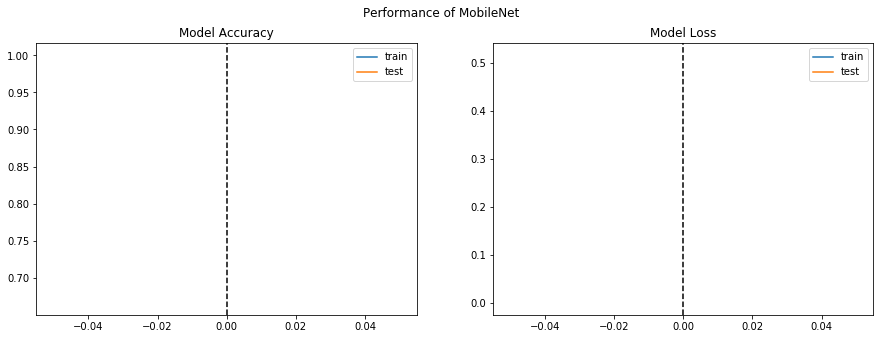

In [92]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of MobileNet")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()

In [32]:
s3 = boto3.client('s3')
model = s3.download_file('sagemaker-pneumonia-detection','model-classification.h5','model.h5')

In [36]:
import os
print(os.getcwd())

C:\Kaustav\Personal\Studies\Tech Stuff\Great Learning\Capstone Project\rsna-pneumonia-detection-challenge\AWS Sagemaker\pneumonia-detection\pneumonia-detection


In [37]:
# method to load the image and read .dcm file using pydicom

def load_image(image_path,img_width,img_height):
    #this method helps in reading .dcm file
    ds = pydicom.dcmread(image_path)
    img = ds.pixel_array
    #calling cv2.resize to reduce the dimension of image
    res = cv2.resize(img, (img_width,img_height), interpolation=cv2.INTER_AREA)
    #converting the image array data into float 
    res = res.astype(np.float32)/255
    cv2.destroyAllWindows()
#     print(type(res))
    res = np.stack((res,) * 3, -1)
    return res


In [42]:
%ls

 Volume in drive C is Windows
 Volume Serial Number is E408-9919

 Directory of C:\Kaustav\Personal\Studies\Tech Stuff\Great Learning\Capstone Project\rsna-pneumonia-detection-challenge\AWS Sagemaker\pneumonia-detection\pneumonia-detection

06/07/2020  10:44 PM    <DIR>          .
06/07/2020  10:44 PM    <DIR>          ..
06/07/2020  03:48 PM    <DIR>          .ipynb_checkpoints
06/07/2020  03:48 PM    <DIR>          container
06/07/2020  10:37 PM        23,894,216 model.h5
06/07/2020  10:44 PM            18,096 Modular Code.ipynb
06/06/2020  03:59 PM            43,329 pneumonia-detection-sagemaker.ipynb
06/06/2020  12:15 PM               154 README.md
               4 File(s)     23,955,795 bytes
               4 Dir(s)  16,359,673,856 bytes free


In [74]:
from tensorflow.keras.models import Model,load_model

os.chdir('./container/model')
print(os.getcwd())
%ls
mobilenet_model_loaded = load_model('model-classification.h5')
mobilenet_model_loaded.summary()

C:\Kaustav\Personal\Studies\Tech Stuff\Great Learning\Capstone Project\rsna-pneumonia-detection-challenge\AWS Sagemaker\pneumonia-detection\pneumonia-detection\container\model
 Volume in drive C is Windows
 Volume Serial Number is E408-9919

 Directory of C:\Kaustav\Personal\Studies\Tech Stuff\Great Learning\Capstone Project\rsna-pneumonia-detection-challenge\AWS Sagemaker\pneumonia-detection\pneumonia-detection\container\model

06/07/2020  03:52 PM    <DIR>          .
06/07/2020  03:52 PM    <DIR>          ..
06/02/2020  08:45 PM        23,939,720 mobilenet_model.h5
06/08/2020  11:55 AM        23,893,968 model-classification.h5
06/04/2020  11:55 PM        23,893,808 model-pneumonia-classification.h5
               3 File(s)     71,727,496 bytes
               2 Dir(s)  15,182,852,096 bytes free


ValueError: No model found in config file.

In [75]:
os.chdir('../../')
print(os.getcwd())

C:\Kaustav\Personal\Studies\Tech Stuff\Great Learning\Capstone Project\rsna-pneumonia-detection-challenge\AWS Sagemaker\pneumonia-detection\pneumonia-detection


In [63]:
from tensorflow.keras.models import Model,load_model

model_path_1 = os.path.join(os.path.join('/container/model','model-classification.h5'))
print(model_path_1)
mobilenet_model_loaded = load_model('model.h5')
# mobilenet_model_loaded.summary()

/container/model\model-classification.h5


ValueError: No model found in config file.